# Notebook to implement DeepDream with pytorch
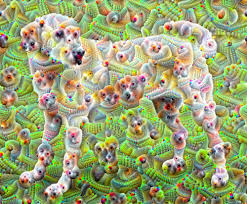

In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision.models as models
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
#Define Model (VGG16)
model = models.vgg16(pretrained=True)
#model = models.inception_v3(pretrained=True)
device = "cuda" if torch.cuda.is_available() else "cpu"
device
model.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [3]:
# Utility functions

# Inputs to VGG have to normalized as such
NormalTransform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


NormalResizeTransform = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


def ImagetoTensor(path, T, resize = False, device="cuda"):
    """
    could be integrated into image_to_tensor
    but applied transformation can change between models
    
    """
    img = np.asarray(Image.open(path))/255
    a = NormalTransform(img).unsqueeze(0)
    return a.to(device).float()
        
def tensortoimage(t):
    mean = np.array([0.485, 0.456, 0.406]).reshape([1, 1, 3])
    std = np.array([0.229, 0.224, 0.225]).reshape([1, 1, 3])
    t = t.squeeze().transpose(0,2).transpose(0,1)
    t = t.detach().cpu().numpy()
    t = std*t+mean
    t=t*255
    t = np.uint8(np.clip(t,0,255))
    img = Image.fromarray(t)
    return img


In [4]:
# Deep dream related code
import scipy.ndimage as nd

def dream_step(model, img, layer_index=10, n_iters=50, lr = 0.1, control=None, category=None):
    """
    passes img through the network for n_iters amount of times
    calculating the loss from the layer_index
    """
    
    
    b = torch.autograd.Variable(img, requires_grad=True)
    
    optimizer = torch.optim.Adam([b], lr =lr)
    mean = np.array([0.485, 0.456, 0.406]).reshape([3, 1, 1])
    std = np.array([0.229, 0.224, 0.225]).reshape([3, 1, 1])
    
    for _ in range(n_iters):
        optimizer.zero_grad()
        out = subnetwork_output(b, model, layer_index, category=category)
        loss = calculate_loss(out, control)
        out.backward(loss)
        optimizer.step()
        
        img_data = b.data.cpu().numpy()
        img_data[0,:,:,:] = np.clip(img_data[0,:,:,:], -mean/std, (1-mean)/std)
        b.data[0,:,:,:]  = torch.tensor(img_data)
        
        #print(loss.item())
        
    return b.data
    
    
    
def subnetwork_output(img, model, layer_index, category=None):
    """
    output of the layer specified by layer_index
    """
    max_layer = get_layer_count(model)
    if layer_index>max_layer:
        print("Layer index is too large")
        raise ValueError
    if category:
        return model(img).squeeze()[category]
        pass
    else:
        x = img
        index=0
        for layer in model.features:
            x = layer(x)
            if 'Conv' in repr(layer):
                index+=1
            if index==layer_index:
                break
    
    return x
def octave_function(img, model, octave_scale=1.3):
    """
    implements the octaves to get deepdream details on multiple scales
    down sizes image deepdreams on that and combine dreams on all scales
    """
def get_layer_count(model):
    return len([1 for layer in model.features if 'Conv' in repr(layer)])

def calculate_loss(features, control=None):
    
    if control!= None:
        ch, w, h = features[0].shape
        a = features.view(ch, -1)
        #print(a.shape)
        b = control.view(ch, -1)
        #print(b.shape)
        A = torch.mm(a.T, b)
        index = torch.max(A, 1)[1]
        return -b[:, index].view(ch, w, h).unsqueeze(0)
    return -features

In [19]:

control = ImagetoTensor('./images/botti.jpg', NormalTransform)
b = ImagetoTensor('./images/sannamarin.jpg', NormalTransform)

layer_index = 12



    

def dreamdeep(img, layer_index, octave_scale, octave_min, octave_max, n_iters, orig_add=True):
    
    h, w = img.size()[2:]
    control_features = None
    for n in range(octave_min, octave_max):
        resize = T.Compose([
            T.Resize((int(h*(octave_scale**n)),int(w*(octave_scale**n))))])

        #control_resized = resize(control)

        new_img = (resize(img))

        if orig_add:
            new_img = (new_img + resize(b))/2
        print(new_img.size())
        img = dream_step(model, new_img, layer_index=layer_index, n_iters=n_iters, control=control_features)
    return img

img = dreamdeep(b, 11, 1.3, -3, 1, 10)
    
tensortoimage(img).show()

torch.Size([1, 3, 142, 213])
torch.Size([1, 3, 184, 276])
torch.Size([1, 3, 239, 359])
torch.Size([1, 3, 312, 468])


In [ ]:
control = ImagetoTensor('./images/botti.jpg', NormalTransform)
b = ImagetoTensor('./images/art.png', NormalTransform)

layer_index = 12


control_features = subnetwork_output(control, model, layer_index = layer_index)
#print(control)
#control_features = None

h, w = b.size()[2:]

print(h ,w)
Octave_scale = 1.4
Octave_range= [i for i in range(-6,1)]
orig_add = True
img = b



for n in Octave_range:
    resize = T.Compose([
        T.Resize((int(h*(Octave_scale**n)),int(w*(Octave_scale**n))))])
    
    #control_resized = resize(control)
    
    new_img = (resize(img))
    
    if orig_add:
        new_img = (new_img + resize(b))/2
    print(new_img.size())
    img = dream_step(model, new_img, layer_index=layer_index, n_iters=100, control=control_features)

In [9]:
b = ImagetoTensor('./images/cat.jpg', NormalTransform)
mean = np.array([0.485, 0.456, 0.406]).reshape([3, 1, 1])
std = np.array([0.229, 0.224, 0.225]).reshape([3, 1, 1])


print(b)
lr = 0.01
optimizer = torch.optim.Adam([b], lr=0.01)
for _ in range(400):
    optimizer.zero_grad()
    out = subnetwork_output(b, model, 13, category=150)
    loss = -out.norm()
    out.backward(out)
    

    optimizer.step()
    #print(b.data)
    img_data = b.data.cpu().numpy()
    img_data[0,:,:,:] = np.clip(img_data[0,:,:,:], -mean/std, (1-mean)/std)
    b.data[0,:,:,:]  = torch.tensor(img_data)
    print(loss.item())
tensortoimage(b).show()

tensor([[[[-1.9980, -1.9809, -1.9638,  ..., -0.5767, -0.7822, -0.9020],
          [-1.9809, -1.9809, -1.9638,  ..., -0.4739, -0.7479, -0.9363],
          [-1.9638, -1.9467, -1.9295,  ..., -0.3198, -0.6794, -0.9363],
          ...,
          [-0.5424, -0.3027, -0.0116,  ..., -1.6727, -1.7069, -1.7583],
          [-0.5938, -0.6452, -0.5082,  ..., -1.4158, -1.2788, -1.3473],
          [-0.5253, -0.4739, -0.3369,  ..., -1.1247, -1.0390, -1.2959]],

         [[-1.7206, -1.7031, -1.6856,  ..., -0.6001, -0.7927, -0.8627],
          [-1.7031, -1.7031, -1.6856,  ..., -0.4951, -0.7577, -0.8978],
          [-1.6856, -1.6506, -1.6506,  ..., -0.3375, -0.6877, -0.9503],
          ...,
          [-0.6176, -0.3725, -0.0749,  ..., -1.6506, -1.6856, -1.7381],
          [-0.6702, -0.7052, -0.5826,  ..., -1.3880, -1.2479, -1.3179],
          [-0.5826, -0.5301, -0.3901,  ..., -1.0903, -1.0028, -1.2654]],

         [[-1.7696, -1.7522, -1.7347,  ..., -1.6476, -1.7870, -1.8044],
          [-1.7522, -1.7696, -

-1.9198333024978638
-0.49862784147262573
-3.3645129203796387
-1.4007984399795532
-0.5658364295959473
-1.1892330646514893
-0.366656094789505
-0.14886048436164856
-1.9530833959579468
-1.2577067613601685
-1.05756676197052
-1.4857865571975708
-1.4684706926345825
-0.4893401861190796
-1.1442307233810425
-0.9601179361343384
-1.1047711372375488
-1.731343150138855
-0.9288011789321899
-0.06228082627058029
-0.7707575559616089
-1.2020608186721802
-0.8501490354537964
-0.22563031315803528
-0.10745862871408463
-2.2867352962493896
-1.6642272472381592
-0.7691823244094849
-0.7138190269470215
-2.2556920051574707
-1.2195883989334106
-1.2700488567352295
-1.0644313097000122
-0.7167806029319763
-1.4968682527542114
-1.4825178384780884
-1.596628189086914
-0.5943275690078735
-1.4859226942062378
-0.7257785797119141
-0.34255948662757874
-1.7087091207504272
-0.8687629699707031
-0.3325997292995453
-0.21675264835357666
-1.6719952821731567
-0.5527729988098145
-0.06183001771569252
-2.6349730491638184
-1.31824016571044

In [8]:
a = torch.randn(4)
a.backward()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [57]:
a = torch.randn(5,5)
b = torch.autograd.Variable(a, requires_grad = True)
c = b*3
loss = c.norm()
loss.backward()
print(b.grad)
b.zero_grad()

tensor([[-0.6111, -0.8829,  0.2583, -0.1770,  0.8233],
        [ 0.6045,  0.0828,  1.0180,  0.0170,  0.9031],
        [ 0.3431,  1.0035,  0.2101, -0.3635, -0.5837],
        [ 0.6153, -0.1957,  0.1752,  0.1244,  0.6454],
        [-0.3743,  0.9341, -0.1483, -0.4171, -1.0568]])


AttributeError: 'Tensor' object has no attribute 'zero_grad'